In [1]:
import numpy as np
import pandas as pd
# import vaex 
import glob
import csv  

from datetime import timedelta
import datetime

import matplotlib.pyplot as plt
import pyodbc
import seaborn as sns

In [2]:
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
# import sklearn_pandas
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split

from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
from sklearn.impute import KNNImputer

import scipy.stats as stats

In [3]:
pd.set_option('display.max_columns', None)


In [4]:
# Read the CSV file
data_origin = pd.read_csv('smoking_driking_dataset_Ver01.csv', sep=',')



In [5]:
data_origin['SMK_stat_type_cd'].value_counts()

SMK_stat_type_cd
1.0    602441
3.0    213954
2.0    174951
Name: count, dtype: int64

In [77]:
df_filtered['SMK_stat_type_cd'].value_counts()

SMK_stat_type_cd
0    602441
1    213954
Name: count, dtype: int64

In [13]:
# check nan value
data_origin.isna().sum()

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64

In [24]:
# check how program read the types of each column
data_origin.dtypes

sex                   int64
age                   int64
height                int64
weight                int64
waistline           float64
sight_left          float64
sight_right         float64
hear_left           float64
hear_right          float64
SBP                 float64
DBP                 float64
BLDS                float64
tot_chole           float64
HDL_chole           float64
LDL_chole           float64
triglyceride        float64
hemoglobin          float64
urine_protein       float64
serum_creatinine    float64
SGOT_AST            float64
SGOT_ALT            float64
gamma_GTP           float64
SMK_stat_type_cd    float64
DRK_YN                int64
dtype: object

In [15]:
# check column value types
data_origin.nunique()

sex                    2
age                   14
height                13
weight                24
waistline            737
sight_left            24
sight_right           24
hear_left              2
hear_right             2
SBP                  171
DBP                  127
BLDS                 498
tot_chole            474
HDL_chole            223
LDL_chole            432
triglyceride        1657
hemoglobin           190
urine_protein          6
serum_creatinine     183
SGOT_AST             568
SGOT_ALT             594
gamma_GTP            940
SMK_stat_type_cd       3
DRK_YN                 2
dtype: int64

### Prediciton model implementation: data preprocess

In [6]:
# Replace values in the 'sex' column
data_origin['sex'] = data_origin['sex'].replace({'Female': 0, 'Male': 1})

# Replace values in the 'DRK_YN' column
data_origin['DRK_YN'] = data_origin['DRK_YN'].replace({'Y': 1, 'N': 0})

In [17]:
# to study some detail informaition about the numeric data information
data_origin.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,991346.0,0.531010,0.499038,0.0,0.0,1.0,1.0,1.0
age,991346.0,47.614491,14.181339,20.0,35.0,45.0,60.0,85.0
height,991346.0,162.240625,9.282957,130.0,155.0,160.0,170.0,190.0
weight,991346.0,63.284050,12.514241,25.0,55.0,60.0,70.0,140.0
waistline,991346.0,81.233358,11.850323,8.0,74.1,81.0,87.8,999.0
sight_left,991346.0,0.980834,0.605949,0.1,0.7,1.0,1.2,9.9
sight_right,991346.0,0.978429,0.604774,0.1,0.7,1.0,1.2,9.9
hear_left,991346.0,1.031495,0.174650,1.0,1.0,1.0,1.0,2.0
hear_right,991346.0,1.030476,0.171892,1.0,1.0,1.0,1.0,2.0
SBP,991346.0,122.432498,14.543148,67.0,112.0,120.0,131.0,273.0


(array([0.5]), [Text(0, 0.5, 'SMK_stat_type_cd')])

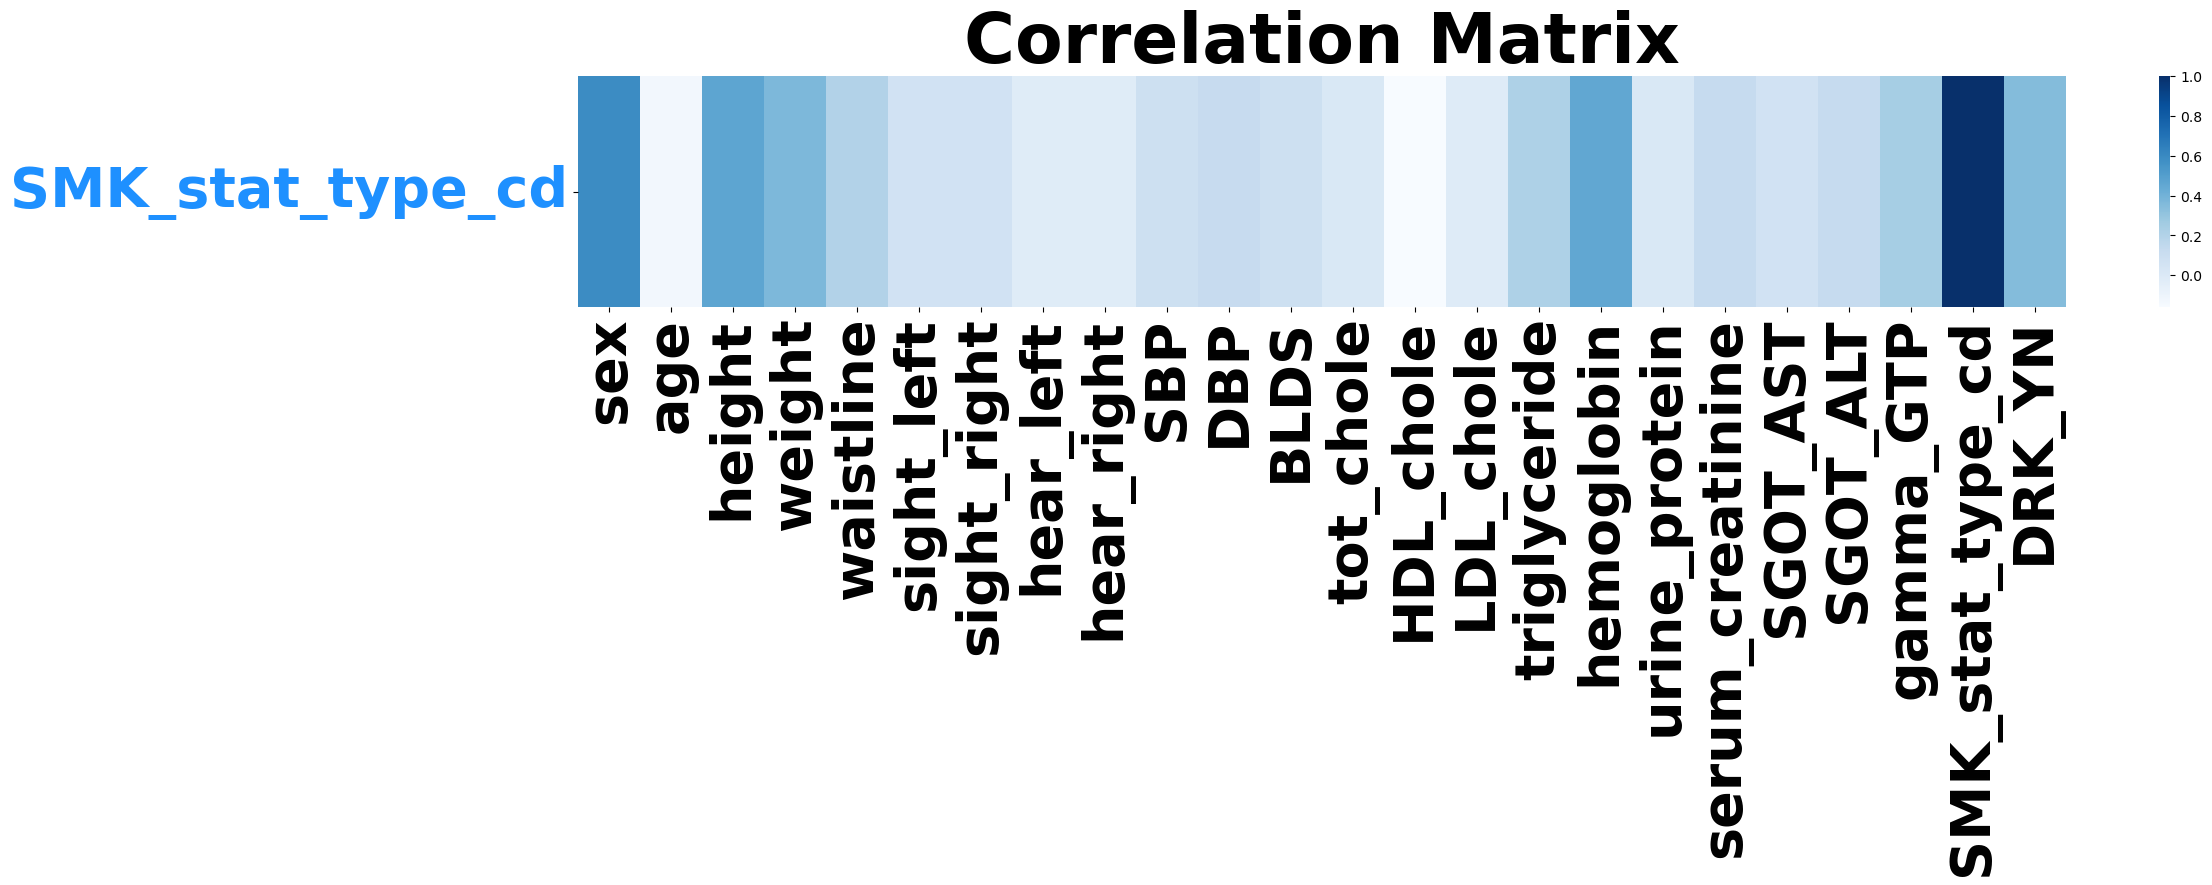

In [7]:
# check column correlations with target column(SMK_stat_type_cd)
df_num = data_origin.select_dtypes(['int64','float64'])
num_corr = df_num.corr()
fig,ax = plt.subplots(figsize=(len(df_num.columns),3))
sns.heatmap(num_corr.sort_values(by=['SMK_stat_type_cd'], ascending=False).head(1), cmap='Blues')
plt.title("Correlation Matrix", weight='bold', fontsize=50)
plt.xticks(weight='bold', fontsize=40)
plt.yticks(weight='bold', fontsize=40, color='dodgerblue', rotation=0)

(array([0.5]), [Text(0, 0.5, 'DRK_YN')])

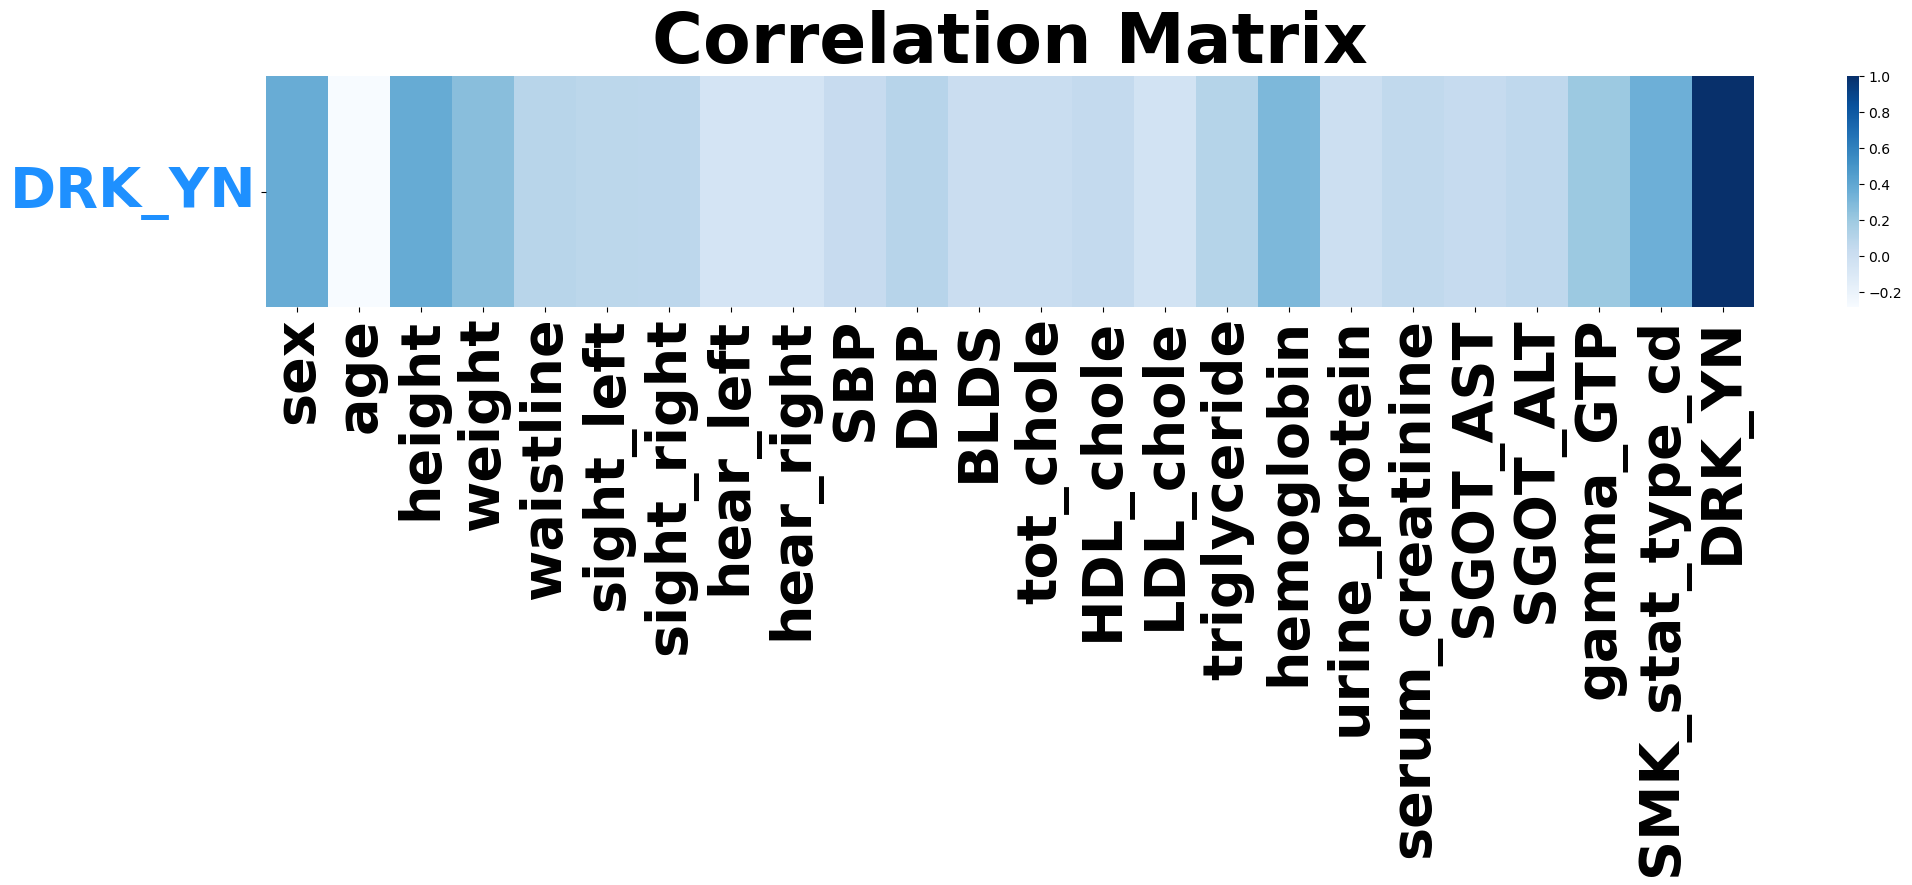

In [8]:
# check column correlations with target column(DRK_YN)
df_num = data_origin.select_dtypes(['int64','float64'])
num_corr = df_num.corr()
fig,ax = plt.subplots(figsize=(len(df_num.columns),3))
sns.heatmap(num_corr.sort_values(by=['DRK_YN'], ascending=False).head(1), cmap='Blues')
plt.title("Correlation Matrix", weight='bold', fontsize=50)
plt.xticks(weight='bold', fontsize=40)
plt.yticks(weight='bold', fontsize=40, color='dodgerblue', rotation=0)

In [9]:
# top 10 corr with 'DRK_YN'
print(num_corr['DRK_YN'].sort_values(ascending=False).iloc[1:11])

height              0.374566
sex                 0.368726
SMK_stat_type_cd    0.350784
hemoglobin          0.299341
weight              0.264282
gamma_GTP           0.205094
triglyceride        0.104398
DBP                 0.100876
waistline           0.092993
sight_left          0.077379
Name: DRK_YN, dtype: float64


In [10]:
# top 10 corr with 'SMK_stat_type_cd'
print(num_corr['SMK_stat_type_cd'].sort_values(ascending=False).iloc[1:11])

sex                 0.591004
height              0.467317
hemoglobin          0.453385
weight              0.366499
DRK_YN              0.350784
gamma_GTP           0.243576
triglyceride        0.216026
waistline           0.205485
SGOT_ALT            0.131569
serum_creatinine    0.129679
Name: SMK_stat_type_cd, dtype: float64


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [28]:
data_origin.head(5)

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,1,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,80.0,99.0,193.0,48.0,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,1
1,1,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,82.0,106.0,228.0,55.0,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,0
2,1,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,70.0,98.0,136.0,41.0,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,0
3,1,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,87.0,95.0,201.0,76.0,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,0
4,1,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,82.0,101.0,199.0,61.0,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,0


In [12]:
# Extracting independent variables
X = data_origin.iloc().copy()
#col_drop = ['radius_mean', 'perimeter_mean', 'radius_worst', 'perimeter_worst', 'fractal_dimension_mean', 'smoothness_worst']
#X = X.drop(columns=col_drop)
# Adding categorical variables if needed
# X = pd.concat([X, pd.get_dummies(df_for_models['diagnosis'], drop_first=True)], axis=1)

# Calculating VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

AttributeError: '_iLocIndexer' object has no attribute 'copy'

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [32]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

# Principal components
principal_components = pd.DataFrame(data=X_pca, columns=[f"PC{i}" for i in range(1, X.shape[1]+1)])
print(principal_components)

[0.19002231 0.09919737 0.08072112 0.06790734 0.0606792  0.05206682
 0.04945918 0.04502215 0.04252248 0.03809219 0.03455888 0.0325696
 0.02919888 0.0288009  0.02608882 0.02370681 0.02089835 0.01929391
 0.01775721 0.01371453 0.0099292  0.00894042 0.00629698 0.00255535]
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       2.015162 -0.962302  0.277031 -0.372770 -0.030322 -0.137712  0.084865   
1       2.750005 -0.692187  1.119271 -0.934705  0.029719 -0.222185 -0.167201   
2       1.151869 -0.833956 -1.693741  1.001259 -0.117363  0.039275 -1.543911   
3       2.200201  0.143800  0.122741 -0.818207 -0.847620  1.331861 -0.121919   
4      -0.157923  0.396142  0.064075 -0.846242 -0.822905  0.664455 -0.134265   
...          ...       ...       ...       ...       ...       ...       ...   
991341  1.540111 -0.683270  0.283344 -0.324274  0.073511  0.200633 -1.799938   
991342  0.844074 -1.495945 -1.573109 -0.787740 -0.659968  0.303271 -1.023407   
991343 -1.34

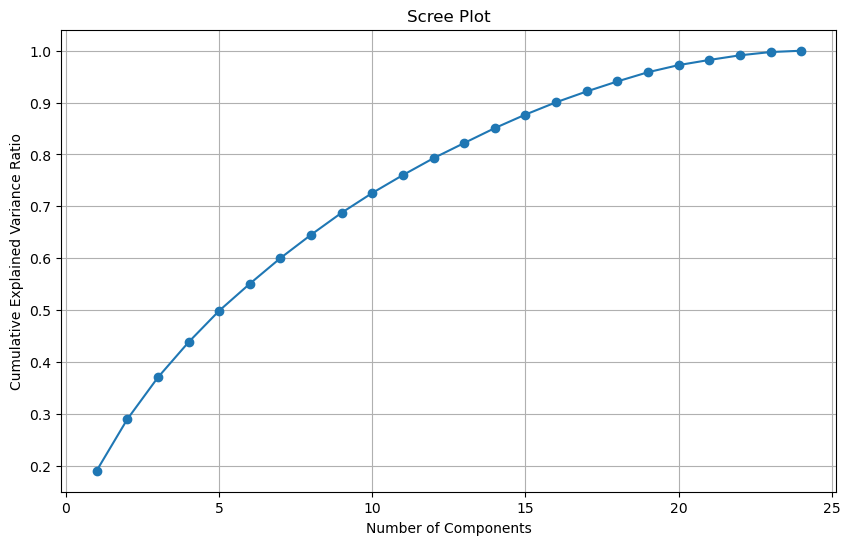

In [33]:
# Calculate cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()

# Plot scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

### implement of Prediction models

In [14]:
# import packages
import math
import sklearn.metrics as sklm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from numpy import sqrt

import sklearn
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score,train_test_split
import scipy.stats as stats

In [15]:
df_filtered = data_origin[data_origin['SMK_stat_type_cd'] != 2]
df_filtered['SMK_stat_type_cd'] = df_filtered['SMK_stat_type_cd'].map({1: 0, 3: 1})


C:\Users\skyba\AppData\Local\Temp\ipykernel_24480\3841974592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['SMK_stat_type_cd'] = df_filtered['SMK_stat_type_cd'].map({1: 0, 3: 1})


In [17]:
df_smokers = data_origin[data_origin['SMK_stat_type_cd'].isin([2, 3])]
df_smokers['SMK_stat_type_cd'] = df_smokers['SMK_stat_type_cd'].map({2: 0, 3: 1})

C:\Users\skyba\AppData\Local\Temp\ipykernel_24480\2844656851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_smokers['SMK_stat_type_cd'] = df_smokers['SMK_stat_type_cd'].map({2: 0, 3: 1})


In [18]:
# data_origin (whole features), lowVIF (LowVIF features), df_corr_top10 (top 10 correlation features), df_lasso_refit (lasso refit selected features)
# data_origin, df_filtered, df_smokers
target_df = df_filtered.copy()

In [ ]:
target_df.head(5)

In [19]:
# Splitting the data

X = target_df.drop('SMK_stat_type_cd',axis=1)
y= target_df['SMK_stat_type_cd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

### scaling the data

In [20]:
# Standardize features
scaler = StandardScaler() # MinMaxScaler() StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model implementation

In [ ]:
# combine multiple model assessments into a function for further use
def multiple_model_assessments(model, fit, model_name):
    
    pred = model.predict(X_test_scaled)
    acc=accuracy_score(y_test,pred) 

    print('------------------------------------')
    # Calculate confusion matrix without normalize
    cm = confusion_matrix(y_test,pred)
    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d',cmap=['blue','orange'])
    plt.title('Confusion matrix of %s'% model_name)
    plt.xlabel('Predcted lablel ( 1 = smoking, 0 = never)')
    plt.ylabel('True lable')
    plt.show()

    print('------------------------------------')
    # Calculate confusion matrix with normalize=True
    cmN = confusion_matrix(y_test,pred, normalize='true')
    # Plot the confusion matrix
    sns.heatmap(cmN, annot=True,cmap=['blue','orange'])
    plt.title('Normalized Confusion matrix of %s'% model_name)
    plt.xlabel('Predcted lablel ( 1 = smoking, 0 = never)')
    plt.ylabel('True lable')
    plt.show()
    
    print('------------------------------------')
    # print reports
    print('Confusion matrix')
    print(cm)
    print('Normalized Confusion matrix')
    print(cmN)
    print(classification_report(y_test,pred))
    print('accuracy_score : ' , acc)
    
    print('------------------------------------')
    
    y_scores = model.predict_proba(X_test_scaled)
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of %s'% model_name)
    plt.show()
    
    print('------------------------------------')
    CV_10_acc = cross_val_score(model, X_test_scaled, y_test, cv=10, scoring='accuracy')
    print('10 Cross validation of accuracy in %s'% model_name)
    print(CV_10_acc)
    print('10 Cross validation of mean accuracy in %s'% model_name)
    print(CV_10_acc.mean()*100,'%')

In [40]:
### KNN

In [22]:
# find near optimal k for knn with sqrt()
N = len(X_train_scaled)
k = sqrt(N)/2
k

377.98015820939594

In [ ]:
# KNN model implementation
knn = KNeighborsClassifier(n_neighbors=int(k))
knn_fit = knn.fit(X_train_scaled,y_train)
knn_y_train = knn_fit.predict(X_train_scaled)
knn_y_test = knn_fit.predict(X_test_scaled)

# validation( train data and validate data)
print('KNN train data RMSE = ' + str(math.sqrt(sklm.mean_squared_error(y_train, knn_y_train))))
print('KNN test data RMSE = ' + str(math.sqrt(sklm.mean_squared_error(y_test, knn_y_test))))

In [ ]:
model_name = 'KNN'
multiple_model_assessments(knn, knn_fit, model_name)

In [ ]:
### LR

In [23]:
LR = LogisticRegression(random_state = 123)
LR_fit = LR.fit(X_train_scaled,y_train)
LR_y_train = LR_fit.predict(X_train_scaled)
LR_y_test = LR_fit.predict(X_test_scaled)

# validation( train data and validate data)
print('Logistic Regression train data RMSE = ' + str(math.sqrt(sklm.mean_squared_error(y_train, LR_y_train))))
print('Logistic Regression test data RMSE = ' + str(math.sqrt(sklm.mean_squared_error(y_test, LR_y_test))))

Logistic Regression train data RMSE = 0.4220834789227791
Logistic Regression test data RMSE = 0.42309597418713424


------------------------------------


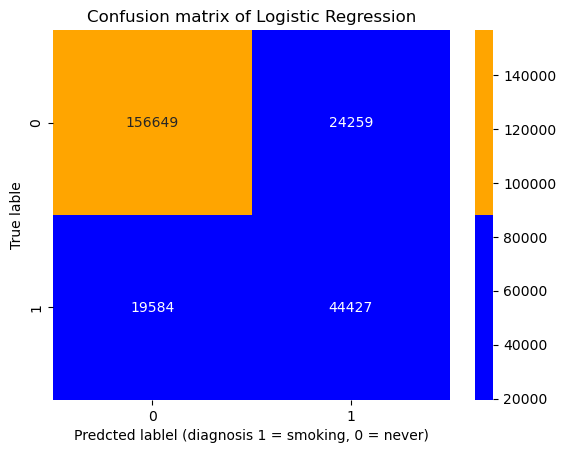

------------------------------------


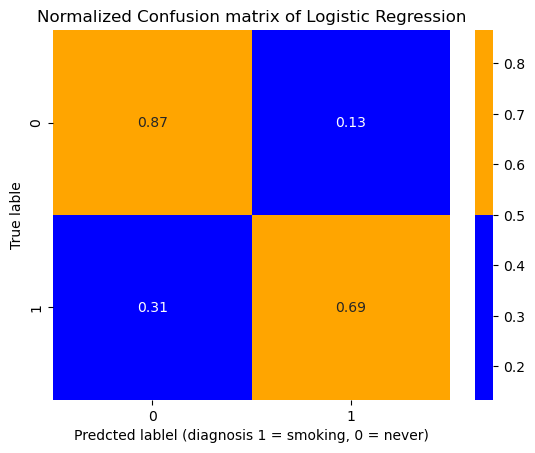

------------------------------------
Confusion matrix
[[156649  24259]
 [ 19584  44427]]
Normalized Confusion matrix
[[0.86590422 0.13409578]
 [0.30594742 0.69405258]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88    180908
           1       0.65      0.69      0.67     64011

    accuracy                           0.82    244919
   macro avg       0.77      0.78      0.77    244919
weighted avg       0.83      0.82      0.82    244919

accuracy_score :  0.8209897966266398
------------------------------------


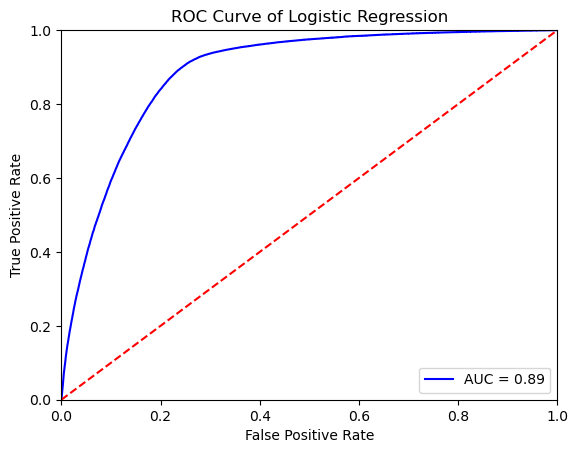

------------------------------------
10 Cross validation of accuracy in Logistic Regression
[0.82002286 0.81994121 0.81569492 0.82508574 0.8236567  0.82484076
 0.82198269 0.81969623 0.81945125 0.81968887]
10 Cross validation of mean accuracy in Logistic Regression
82.10061231784472 %


In [24]:
model_name = 'Logistic Regression'
multiple_model_assessments(LR, LR_fit, model_name)

In [ ]:
### SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Initialize the SVM classifier
svm_clf = SVC(probability=True)

# Grid Search to find the best SVM parameters for the full dataset
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    # 'C': np.arange(0.01, 20, 0.1),
    'gamma': ['scale', 1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(svm_clf, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_full_standard, y)

# Output the best parameters and the best score from Grid Search
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters:", best_params)
print("Best cross-validated accuracy:", best_score)

In [ ]:
### RF

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [26]:
# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=123)  # You can tune these parameters

# Fit the model using the scaled training data
RF_fit = random_forest_model.fit(X_train_scaled, y_train)

# Predict using the scaled test data
y_pred = random_forest_model.predict(X_test_scaled)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.83
Confusion Matrix:
[[161036  19872]
 [ 20832  43179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    180908
           1       0.68      0.67      0.68     64011

    accuracy                           0.83    244919
   macro avg       0.79      0.78      0.78    244919
weighted avg       0.83      0.83      0.83    244919



In [ ]:
# Standardize the full dataset before applying cross-validation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Assuming X is your features dataset without the target

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=123)

# Compute 10-fold cross-validation scores for accuracy
cv_accuracy_scores = cross_val_score(random_forest_model, X_scaled, y, cv=10, scoring='accuracy')
mean_cv_accuracy = cv_accuracy_scores.mean()

# Compute predicted probabilities for AUC using cross-validation
y_scores = cross_val_predict(random_forest_model, X_scaled, y, cv=10, method='predict_proba')
y_scores = y_scores[:, 1]  # get the score for the positive class

# Compute AUC
auc_score = roc_auc_score(y, y_scores)

# Print the results
print(f"Full Dataset - RF 10 CV Accuracy: {mean_cv_accuracy:.2f}")
print(f"Full Dataset - RF 10 CV AUC: {auc_score:.2f}")

------------------------------------


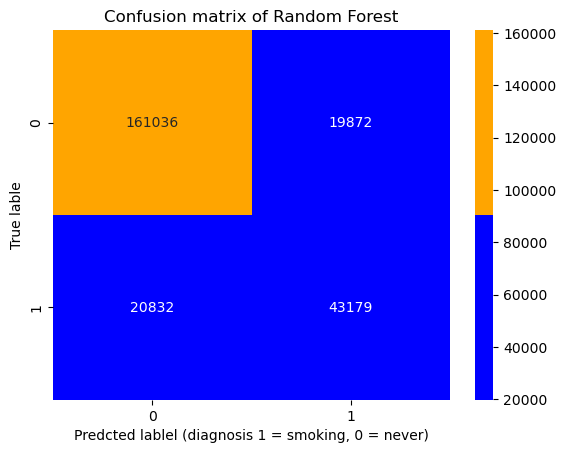

------------------------------------


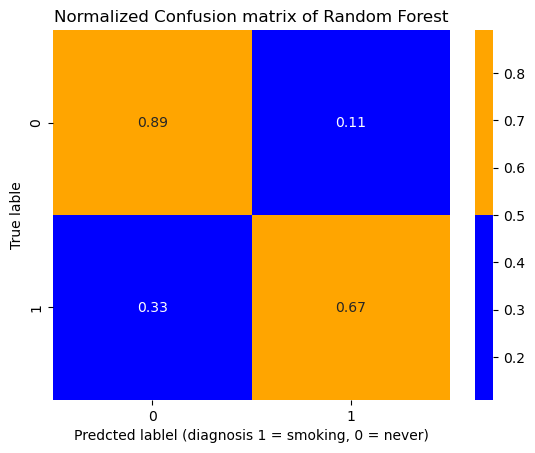

------------------------------------
Confusion matrix
[[161036  19872]
 [ 20832  43179]]
Normalized Confusion matrix
[[0.89015411 0.10984589]
 [0.32544406 0.67455594]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89    180908
           1       0.68      0.67      0.68     64011

    accuracy                           0.83    244919
   macro avg       0.79      0.78      0.78    244919
weighted avg       0.83      0.83      0.83    244919

accuracy_score :  0.8338062788105455
------------------------------------


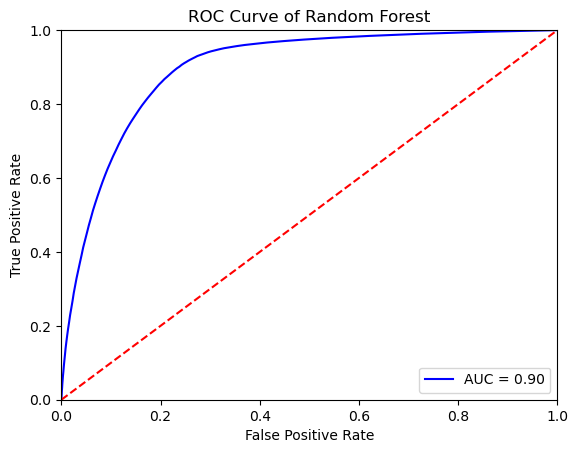

------------------------------------


In [ ]:
model_name = 'Random Forest'
multiple_model_assessments(random_forest_model, RF_fit, model_name)

In [ ]:
### lassco refit for feature selection

In [57]:
from sklearn.linear_model import LassoCV

In [62]:
Lasso = LassoCV(cv=10, max_iter=10000, alpha=0.01)
Lasso_fit=Lasso.fit(X_train_scaled,y_train)
lasso_y_train=Lasso_fit.predict(X_train_scaled)
lasso_y_test=Lasso_fit.predict(X_test_scaled)

# validation( train data and validate data)
print('Lasso train data RMSE = ' + str(math.sqrt(sklm.mean_squared_error(y_train, lasso_y_train))))
print('Lasso test data RMSE = ' + str(math.sqrt(sklm.mean_squared_error(y_test, lasso_y_test))))

TypeError: LassoCV.__init__() got an unexpected keyword argument 'alpha'

In [59]:
optimal_alpha = Lasso.alpha_
optimal_alpha

0.0004836357561486122

In [60]:
# Select features with non-zero coefficients
active_set_indices = [i for i, coef in enumerate(Lasso.coef_) if coef != 0]
X_train_active_Lasso = X_train_scaled[:, active_set_indices]
X_test_active_Lasso = X_test_scaled[:, active_set_indices]
# y_train_active_Lasso = y_train[:, active_set_indices]

In [61]:
count = 0
lasso_selected_list = ['SMK_stat_type_cd']
for idx in active_set_indices:
    count = count+1
    print("Selected feature:", X_train.columns[idx])
    lasso_selected_list.append(X_train.columns[idx])
print(count)
# diagnosis	texture_se	area_se	smoothness_se	concavity_se	symmetry_se	fractal_dimension_se	concavity_worst

Selected feature: sex
Selected feature: age
Selected feature: height
Selected feature: weight
Selected feature: waistline
Selected feature: sight_left
Selected feature: sight_right
Selected feature: hear_left
Selected feature: hear_right
Selected feature: SBP
Selected feature: DBP
Selected feature: BLDS
Selected feature: tot_chole
Selected feature: HDL_chole
Selected feature: LDL_chole
Selected feature: triglyceride
Selected feature: hemoglobin
Selected feature: urine_protein
Selected feature: serum_creatinine
Selected feature: SGOT_AST
Selected feature: SGOT_ALT
Selected feature: gamma_GTP
Selected feature: DRK_YN
23


In [ ]:
# df_lasso_refit = df_for_models[lasso_selected_list].copy()
df_lasso_refit = df_for_models[selected_features].copy()

In [69]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
# y = y.replace({'case': 1, 'control': 0})

lasso = Lasso(alpha=0.01)  # You can tune the alpha value
lasso.fit(X_train_scaled, y_train)
# Get the coefficients
coef = lasso.coef_
print(coef)
# Create a mask for non-zero coefficients
non_zero_mask = coef != 0

# Get the selected features
selected_features = X.columns[non_zero_mask]

# Print the selected features
print("Selected features:", selected_features)

[ 0.35651837 -0.01672866  0.02739261 -0.         -0.         -0.
 -0.         -0.         -0.         -0.01005958 -0.          0.
 -0.         -0.00869962 -0.          0.04777695  0.05310524  0.
 -0.         -0.00380601 -0.          0.04917037  0.10069536]
Selected features: Index(['sex', 'age', 'height', 'SBP', 'HDL_chole', 'triglyceride',
       'hemoglobin', 'SGOT_AST', 'gamma_GTP', 'DRK_YN'],
      dtype='object')


In [65]:
y.value_counts()

SMK_stat_type_cd
1.0    602441
3.0    213954
2.0    174951
Name: count, dtype: int64